# Exploratory Data Analysis

## Imports

In [ ]:
import pandas as pd
from dataframeinfo import DataFrameInfo
from dataframetransform import DataFrameTransform
from datatransform import DataTransform
from plotter import Plotter

df = pd.read_csv('loan_payments_versions/loan_payments.csv', index_col='id')

data = DataTransform()
info = DataFrameInfo()
plotter = Plotter()
transform = DataFrameTransform()

## Formatting the data

Used the DataTransform class to correct incorrect formats. Firstly, the 'verification_status' column needed to be formatted since it contained the strings 'Source Verified' and 'Verified' which both have the same meaning:

In [ ]:
data.replace_string_text(df, 'verification_status', 'Source ', '')
date_columns = ['issue_date', 'earliest_credit_line', 'last_payment_date', 'next_payment_date', 'last_credit_pull_date']
for column in date_columns:
    data.convert_string_to_date(df, column) 

Next columns with dates which were in string format needed to be changed into a period format date:

In [ ]:
def convert_date(self, DataFrame: pd. DataFrame, column_name: str):
    DataFrame [column_name] = pd.to_datetime(DataFrame[column_name], errors='coerce').dt.to_period('M')
    return DataFrame

## Null Values

To address null values in our dataframe, we first need to understand what percentage of each column contains null values.

In [ ]:
null_columns = info.get_null_columns(df)
for column in null_columns: 
    print(f'{column}: {round(info.null_percentage(df, column),2)} %') 

Columns which contained a high number of null values needed to be dropped.

In [ ]:
columns_to_remove = info.identify_conditional_null_columns(df, '>', 10)
transform.remove_null_columns(df, columns_to_remove) 

Columns which contain less than 1% null values do not need values imputed - instead, the rows can be removed.

In [ ]:
columns_with_rows_to_remove = info.identify_conditional_null_columns(df, '<', 1) 
transform.remove_null_rows(df, columns_with_rows_to_remove)
plotter.missing_matrix(df) 

## Addressing Skewness

To correct skewness it was nessecary to first identfiy which columns were skewed. The skewness threshold was set to 0.5.

In [ ]:
skewed_columns = info.get_skewed_columns(df, 0.5)
info.get_skewness(df, skewed_columns)
plotter.facet_grid_histogram(df, skewed_columns)

The compare_skewness_transformations() method defined in the Plotter class was used visualise the effect of transformations on skewness.

In [ ]:
plotter.compare_skewness_transformations(df, 'annual_inc')

# List of columns to be transformed by each method:
box_cox_list = ['loan_amount', 'funded_amount', 'instalment', 'annual_inc', 'total_payment', 'total_rec_int']
yeo_johnson_list = ['funded_amount_inv', 'open_accounts', 'total_accounts', 'total_payment_inv', 'total_rec_prncp', 'last_payment_amount']

# Visualising skewness correction and normalised value count of 'total_rec_late_fees':
plotter.compare_skewness_transformations(df, 'total_rec_late_fee')
df['total_rec_late_fee'].value_counts(normalize=True)

# Performing Box-Cox transformations:
for column in box_cox_list:
    df[column] = transform.box_cox_transform(df, column).values

# Performing Yeo-Johnson transformations:
for column in yeo_johnson_list:
    df[column] = transform.yeo_johnson_transform(df, column).values

plotter.before_after_skewness_transformation(df, 'total_payment')

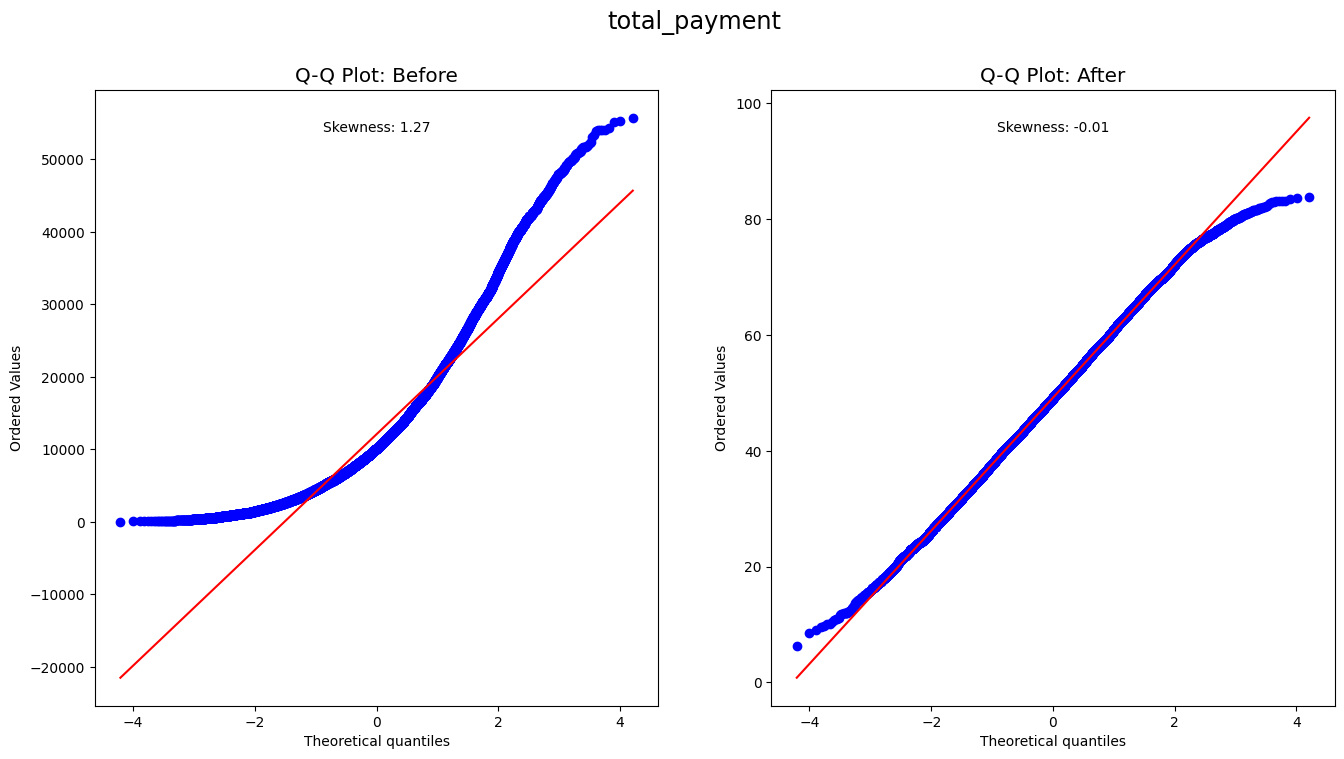

## Remove Outliers

Box-plots were generated to identify which columns need to be transformed to deal with outliers and then outliers were removed from the relevant columns.

In [ ]:
numeric_columns = info.get_numeric_columns(df)
plotter.facet_grid_box_plot(df, numeric_columns)

# List of columns identified with outliers that need to be removed.
outlier_columns = ['loan_amount', 'funded_amount', 'funded_amount_inv', 'int_rate', 'instalment', 'annual_inc', 'dti', 'open_accounts' 'total_accounts', 'total_payment', 'total_payment_inv', 'total_rec_prncp', 'total_rec_int', 'last_payment_amount']

for column in outlier_columns: # For each column that will have outliers removed.
    df = transform.drop_outlier_rows(df, column, 3) # Drop the rows which contain 'z score' greater than 3 for the column being iterated.